
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy/v0.12?urlpath=lab/tree/spectrum_fitting_with_sherpa.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/tutorials).
- **Source files:**
[spectrum_fitting_with_sherpa.ipynb](../_static/notebooks/spectrum_fitting_with_sherpa.ipynb) |
[spectrum_fitting_with_sherpa.py](../_static/notebooks/spectrum_fitting_with_sherpa.py)
</div>


# Fitting gammapy spectra with sherpa

Once we have exported the spectral files (PHA, ARF, RMF and BKG) in the OGIP format, it becomes possible to fit them later with gammapy or with any existing OGIP compliant tool such as XSpec or sherpa.

We show here how to do so with sherpa using the high-level user interface. For a general view on how to use stand-alone sherpa, see https://sherpa.readthedocs.io.

## Load data stack

- We first need to import the user interface and load the data with [load_data](http://cxc.harvard.edu/sherpa/ahelp/load_data.html).
- One can load files one by one, or more simply load them all at once through a [DataStack](http://cxc.harvard.edu/sherpa/ahelp/datastack.html).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import glob  # to list files
from os.path import expandvars
from sherpa.astro.datastack import DataStack
import sherpa.astro.datastack as sh

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [2]:
import sherpa

sherpa.__version__

'4.10.2'

In [3]:
ds = DataStack()
ANALYSIS_DIR = expandvars("$GAMMAPY_DATA/joint-crab/spectra/hess/")
filenames = glob.glob(ANALYSIS_DIR + "pha_obs*.fits")
for filename in filenames:
    sh.load_data(ds, filename)

# see what is stored
ds.show_stack()

read ARF file /Users/adonath/data/gammapy-datasets/joint-crab/spectra/hess/arf_obs23559.fits
read RMF file /Users/adonath/data/gammapy-datasets/joint-crab/spectra/hess/rmf_obs23559.fits
read background file /Users/adonath/data/gammapy-datasets/joint-crab/spectra/hess/bkg_obs23559.fits
read ARF file /Users/adonath/data/gammapy-datasets/joint-crab/spectra/hess/arf_obs23523.fits
read RMF file /Users/adonath/data/gammapy-datasets/joint-crab/spectra/hess/rmf_obs23523.fits
read background file /Users/adonath/data/gammapy-datasets/joint-crab/spectra/hess/bkg_obs23523.fits
read ARF file /Users/adonath/data/gammapy-datasets/joint-crab/spectra/hess/arf_obs23592.fits
read RMF file /Users/adonath/data/gammapy-datasets/joint-crab/spectra/hess/rmf_obs23592.fits
read background file /Users/adonath/data/gammapy-datasets/joint-crab/spectra/hess/bkg_obs23592.fits
read ARF file /Users/adonath/data/gammapy-datasets/joint-crab/spectra/hess/arf_obs23526.fits
read RMF file /Users/adonath/data/gammapy-dataset

## Define source model

We can now use sherpa models. We need to remember that they were designed for X-ray astronomy and energy is written in keV. 

Here we start with a simple PL.

In [4]:
# Define the source model
ds.set_source("powlaw1d.p1")

# Change reference energy of the model
p1.ref = 1e9  # 1 TeV = 1e9 keV
p1.gamma = 2.0
p1.ampl = 1e-20  # in cm**-2 s**-1 keV**-1

# View parameters
print(p1)

powlaw1d.p1
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   p1.gamma     thawed            2          -10           10           
   p1.ref       frozen        1e+09 -3.40282e+38  3.40282e+38           
   p1.ampl      thawed        1e-20            0  3.40282e+38           


## Fit and error estimation

We need to set the correct statistic: [WSTAT](http://cxc.harvard.edu/sherpa/ahelp/wstat.html). We use functions [set_stat](http://cxc.harvard.edu/sherpa/ahelp/set_stat.html) to define the fit statistic, [notice](http://cxc.harvard.edu/sherpa/ahelp/notice.html) to set the energy range, and [fit](http://cxc.harvard.edu/sherpa/ahelp/fit.html).

In [5]:
### Define the statistic
sh.set_stat("wstat")

### Define the fit range
ds.notice(0.6e9, 20e9)

### Do the fit
ds.fit()

Datasets              = 1, 2, 3, 4
Method                = levmar
Statistic             = wstat
Initial fit statistic = 687.716
Final fit statistic   = 158.732 at function evaluation 195
Data points           = 128
Degrees of freedom    = 126
Probability [Q-value] = 0.0257379
Reduced statistic     = 1.25977
Change in statistic   = 528.985
   p1.gamma       2.61709      +/- 0           
   p1.ampl        4.33145e-20  +/- 1.9118e-21  


## Results plot

Note that sherpa does not provide flux points. It also only provides plot for each individual spectrum.

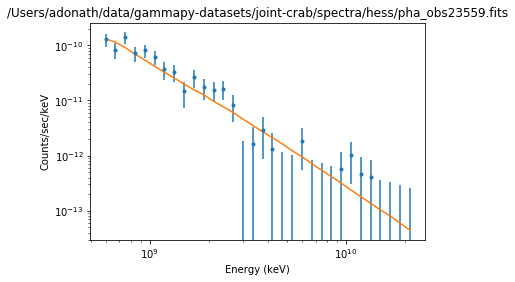

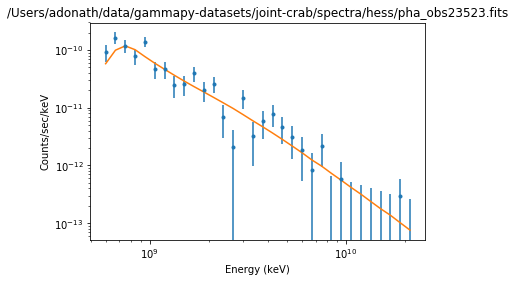

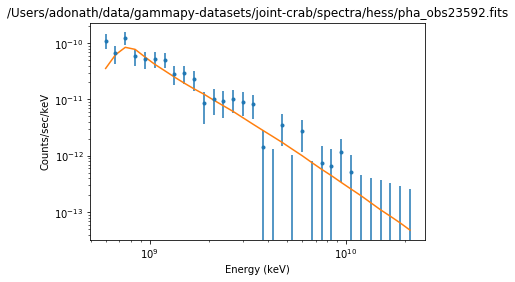

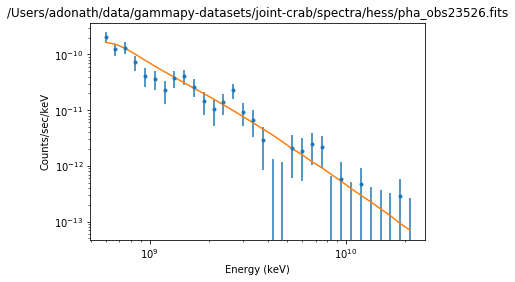

In [6]:
sh.get_data_plot_prefs()["xlog"] = True
sh.get_data_plot_prefs()["ylog"] = True
ds.plot_fit()

## Errors and confidence contours

We use [conf](http://cxc.harvard.edu/sherpa/ahelp/conf.html) and [reg_proj](http://cxc.harvard.edu/sherpa/ahelp/reg_proj.html) functions.

In [7]:
# Compute confidence intervals
ds.conf()

p1.ampl lower bound:	-2.00854e-21
p1.gamma lower bound:	-0.0625337
p1.ampl upper bound:	2.0723e-21
p1.gamma upper bound:	0.0637839
Datasets              = 1, 2, 3, 4
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = wstat
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   p1.gamma          2.61709   -0.0625337    0.0637839
   p1.ampl       4.33145e-20 -2.00854e-21   2.0723e-21


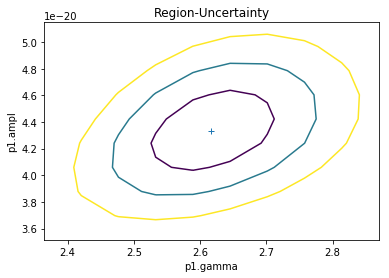

In [8]:
# Compute confidence contours for amplitude and index
sh.reg_unc(p1.gamma, p1.ampl)

## Exercises

- Change the energy range of the fit to be only 2 to 10 TeV
- Fit the built-in Sherpa exponential cutoff powerlaw model
- Define your own spectral model class (e.g. powerlaw again to practice) and fit it